# Gaussian processes: inference

In the previous chapter we have seen how to generate Gaussian process *priors*. But what we usually would want to do is *inference*. A typical model that we will deal with in practice, has the following form:

$$
\begin{aligned}
f(x) &\sim \mathcal{GP}(\mu(x), k(x, x')), \\
y  &\vert f \sim \Pi_i p(y_i \vert f(x_i)).
\end{aligned}
$$

Here $y_i$ is the observed data, and $x_i$ are the locations of those observations; $f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))$ gives a Gaussian process prior and the role of $f(x)$ now is to serve as a latent field capturing dependencies between locations $x$. The expression $\Pi_i p(y_i \vert f(x_i))$ provides a likliehood, allowing us to link observed data to the model allowing to infer parameters.

The task that we usually want to solve is twofold:

```{margin}
The task of predicting at unobserved locations is often referred to as **kriging** and is the underlying concenpt in spatial statistics. We will talk about it in the next chapter.
```

- infer parameters involed in the model,
- make predictions at unobserved locations $x_*.$

## Gaussian process regression

The simplest case of the setting described above is the Gaussian process regression where the outcome variable is modelled as a GP with added noise $\epsilon$. It assumes that the data consists of pais $\{(x_i, y_i)\}_{i=1}^n$ and the likeihood is Gaussian with variance $\sigma^2_\epsilon:$

$$
f(x) \sim \mathcal{GP}(\mu(x), k(x, x')),\\
y_i = f(x_i) + \epsilon_i, \\
\epsilon_i \sim \mathcal{N}(0, \sigma^2_\epsilon).
$$


In Gaussian process regression, the predictive distribution for an unobserved location $x_*$ given the observed data $x$ and $y$ is Gaussian, with a mean and covariance determined by the kernel function $k$, which characterizes the underlying assumptions about the data's covariance structure.

### Predictive distribution

For prediction $y_*$ at a new location $x_*$, the predictive distribution is 

$$
y_* | x_*, x, y \sim \mathcal{N}(\mu_*, \sigma^2_*),
$$

where 

- $\mu_*$ is the mean of the predictive distribution,
- $\sigma^2_*$ is the variance of the predictive distribution.

The mean and variance of the predictive distribution can be computed as follows:

1. **Mean** ($\mu_*$):
$$
\mu_* = k_* (K+\sigma^2_\epsilon I)^{-1}y
$$

where

- $k_*$ is the vector of covariances between the test point $x_*$ and each training point,
- $K$ is the $n \times n$ covariance matrix between all pairs of input ("training") points,
- $\sigma^2_\epsilon$ is the noise variance term,
- $I$ is the identity matrix.


2. **Variance** ($\sigma^2_*$):

$$
\sigma_* = k(x_*, x_*) - k_* (K+\sigma^2_\epsilon I)^{-1}k_*^T
$$

**Task**: check that you understand and agree with dimensionality of all matrices involved in these computations.

Parameters $\theta$ of the model can be learnt using the marginal log-likelihood:

$$
\log p(y|\theta)= -\frac{n}{2} \log(2\pi) - \frac{1}{2}\log \vert K + \sigma^2_\epsilon I \vert - \frac{1}{2}y^T(K + \sigma^2_\epsilon I)^{-1}y
$$

## Computational complexity

Note that the predictive distribution involes inversion of a $n \times n$ matrix. This computation has cubic complexity $O(n^3)$ with respect to the numhber of points $n$ and creates a computational bottleneck when dealing with GP inference.

In [1]:
# imports for this chapter
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)  # Set the device count to enable parallel sampling

/opt/anaconda3/envs/aims/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us implement the predictive distribution.

In [2]:
def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

In [3]:
def plot_gp(x_obs, y_obs, x_pred, mean, variance):
    """
    Plots the Gaussian process predictive distribution.

    Args:
    - x_obs: Training inputs, shape (n_train_samples, n_features).
    - y_train: Training targets, shape (n_train_samples,).
    - x_pred: Test input points, shape (n_test_samples, n_features).
    - mean: Mean of the predictive distribution, shape (n_test_samples,).
    - variance: Variance of the predictive distribution, shape (n_test_samples,).
    """
    plt.figure(figsize=(6, 4))
    plt.scatter(x_obs, y_obs, c='red', label='Training Data')
    plt.plot(x_pred, mean, label='Mean Prediction', color='blue')
    plt.fill_between(x_pred.squeeze(), mean - jnp.sqrt(variance), mean + jnp.sqrt(variance), color='lightblue', alpha=0.3, label='Uncertainty')
    plt.title('Gaussian Process Predictive Distribution')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [4]:
def predict_gaussian_process(x_obs, y_obs, x_pred, length_scale=1.0, variance=1.0, noise=1e-8):
    """
    Predicts the mean and variance of the Gaussian process at test points.

    Args:
    - x_obs: Training inputs, shape (n_train_samples, n_features).
    - y_obs: Training targets, shape (n_train_samples,).
    - x_pred: Test input points, shape (n_test_samples, n_features).
    - length_scale: Length scale parameter.
    - variance: Variance parameter.
    - noise: Observational noise.

    Returns:
    - mean: Mean of the predictive distribution, shape (n_test_samples,).
    - variance: Variance of the predictive distribution, shape (n_test_samples,).
    """
    K = rbf_kernel(x_obs, x_obs, length_scale, variance) + noise * jnp.eye(len(x_obs))
    K_inv = jnp.linalg.inv(K)
    K_star = rbf_kernel(x_obs, x_pred, length_scale, variance)
    K_star_star = rbf_kernel(x_pred, x_pred, length_scale, variance)

    mean = jnp.dot(K_star.T, jnp.dot(K_inv, y_obs))
    variance = jnp.diag(K_star_star) - jnp.sum(jnp.dot(K_star.T, K_inv) * K_star.T, axis=1)

    return mean, variance

I0000 00:00:1708541010.357200       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


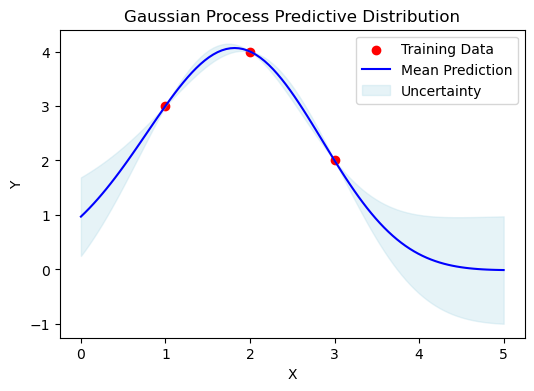

In [5]:
# Example usage:
x_obs = jnp.array([[1], [2], [3]])  # Training inputs
y_obs = jnp.array([3, 4, 2])         # Training targets
x_pred = jnp.linspace(0, 5, 100).reshape(-1, 1)  # Test input points

mean, variance = predict_gaussian_process(x_obs, y_obs, x_pred)
plot_gp(x_obs, y_obs, x_pred, mean, variance)

## Non-Gaussian likelihoods

When the likelihood is non-Gaussian, such as when dealing with binary or count data (e.g., logistic or Poisson likelihood), the resulting posterior distribution is no longer Gaussian, and obtaining a closed-form expression for the predictive distribution may be challenging or impossible. 

In such cases, computational methods such as Markov Chain Monte Carlo or Variational Inference are often used to approximate the predictive distribution. We will use Numpyro and its MCMC engine for this purpose.

## Draw GP priors using Numpyro functionality

In the previous chapter we saw how to draw GP priors numerically. While we don't necessarily *need* Numpyro to do inference in the case of Gaussian likelihood, we will soon see that we will *need* Numpyro for inference in other cases. 

Let us start building that code by drawing GP priors using Numpyro functionality.

In [6]:
def plot_gp_samples(x, samples, ttl="", num_samples=10):
    
    # Plot the samples
    plt.figure(figsize=(6, 4))
    for i in range(num_samples):
        plt.plot(x, samples[i], label=f'Sample {i}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

In [7]:
def model(x, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):    
    """
    Gaussian Process prior with a Numpyro model.

    Args:
    - x (jax.numpy.ndarray): Input data points of shape (n, d), where n is the number of points and d is the number of dimensions.
    - kernel_func (function): Kernel function to use. Default is rbf_kernel.
    - lengthscale (float): Length scale parameter for the kernel function. Default is 0.2.
    - jitter (float): Small constant added to the diagonal of the kernel matrix for numerical stability. Default is 1e-5.

    Returns:
    - numpyro.sample: A sample from the Multivariate Normal distribution representing the function values at input points.
    """

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))
    return f



In [8]:
def model(x, y=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5, noise=0.2):    
    """
    Gaussian Process prior with a Numpyro model.

    Args:
    - x (jax.numpy.ndarray): Input data points of shape (n, d), where n is the number of points and d is the number of dimensions.
    - kernel_func (function): Kernel function to use. Default is rbf_kernel.
    - lengthscale (float): Length scale parameter for the kernel function. Default is 0.2.
    - jitter (float): Small constant added to the diagonal of the kernel matrix for numerical stability. Default is 1e-5.

    Returns:
    - numpyro.sample: A sample from the Multivariate Normal distribution representing the function values at input points.
    """

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))
    
    if y is None:
        numpyro.sample("y", dist.Normal(f, noise))
    else:
        numpyro.sample("y", dist.Normal(f, noise), obs=y)

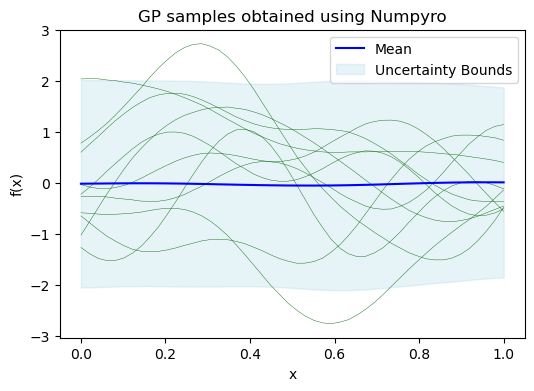

In [9]:
# Define parameters
n_points = 50
num_samples = 1000

# Generate random input data
x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

mcmc_predictive = Predictive(model, num_samples=num_samples)
samples = mcmc_predictive(jax.random.PRNGKey(0), x=x)
f_samples = samples['f']

# Calculate mean and standard deviation
mean = jnp.mean(f_samples, axis=0)
std = jnp.std(f_samples, axis=0)

# Visualization
plt.figure(figsize=(6, 4))
for i in range(10):
    plt.plot(x, f_samples[i], color='darkgreen', lw=0.3)
plt.plot(x, mean, 'b-', label='Mean')  # Point-wise mean of all samples
plt.fill_between(x.squeeze(), mean - 1.96 * std, mean + 1.96 * std, color='lightblue', alpha=0.3, label='Uncertainty Bounds')  # Uncertainty bounds
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('GP samples obtained using Numpyro')    
plt.legend()
plt.show()

## Inference with Numpyro: known noise

For inference, we will use the simulated data in the previous step as input.

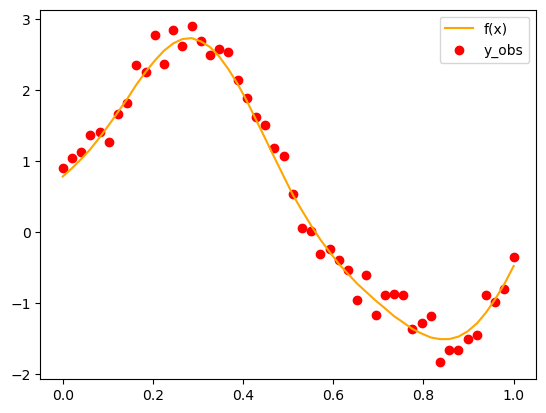

In [10]:
true_idx = 3

y_samples = samples['y']
f_true = f_samples[true_idx]
y_obs =  y_samples[true_idx]

plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x, y_obs, color='red', label='y_obs')
plt.legend()
plt.show()


Let us see whether we can recover $f$ from observed $y$-values. At this stage we assume that the amount of noise is known exactly.

In [11]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel')
mcmc.run(jax.random.PRNGKey(42), x, y_obs)

Running chain 1: 100%|██████████| 12000/12000 [00:09<00:00, 1327.76it/s]


In [12]:
# Print summary statistics of posterior
mcmc.print_summary()

# Get the posterior samples
posterior_samples = mcmc.get_samples()
f_posterior = posterior_samples['f']


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.88      0.13      0.88      0.67      1.09   4429.00      1.00
      f[1]      0.99      0.10      0.99      0.82      1.15   4154.85      1.00
      f[2]      1.11      0.08      1.11      0.97      1.24   3998.21      1.00
      f[3]      1.25      0.07      1.25      1.12      1.37   3960.78      1.00
      f[4]      1.40      0.07      1.40      1.29      1.52   3931.99      1.00
      f[5]      1.57      0.07      1.57      1.46      1.69   3888.32      1.00
      f[6]      1.75      0.07      1.76      1.63      1.87   3837.27      1.00
      f[7]      1.94      0.07      1.94      1.82      2.06   3780.30      1.00
      f[8]      2.12      0.07      2.12      2.00      2.24   3730.13      1.00
      f[9]      2.30      0.07      2.30      2.18      2.42   3658.76      1.00
     f[10]      2.46      0.07      2.46      2.34      2.57   3581.39      1.00
     f[11]      2.59      0

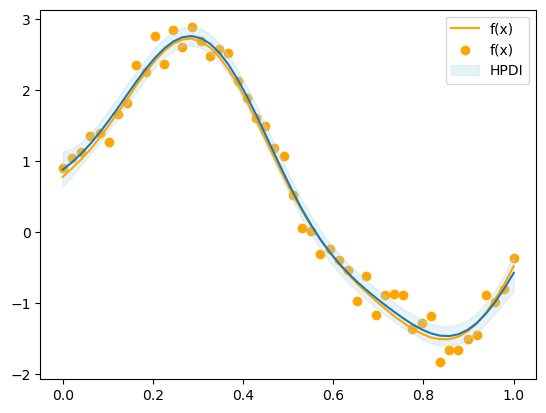

In [13]:
# Calculate mean and standard deviation
f_mean = jnp.mean(f_posterior, axis=0)
f_hpdi = hpdi(f_posterior, 0.95)

plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x, y_obs, color='orange', label='f(x)')
plt.plot(x, f_mean)
plt.fill_between(x.squeeze(), f_hpdi[0], f_hpdi[1], color='lightblue', alpha=0.3, label='HPDI')  # Uncertainty bounds
plt.legend()
plt.show()

## Inference with Numpyro: estimating noise

In [14]:
def model(x, y=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):    
    """
    Gaussian Process prior with a Numpyro model.

    Args:
    - x (jax.numpy.ndarray): Input data points of shape (n, d), where n is the number of points and d is the number of dimensions.
    - kernel_func (function): Kernel function to use. Default is rbf_kernel.
    - lengthscale (float): Length scale parameter for the kernel function. Default is 0.2.
    - jitter (float): Small constant added to the diagonal of the kernel matrix for numerical stability. Default is 1e-5.

    Returns:
    - numpyro.sample: A sample from the Multivariate Normal distribution representing the function values at input points.
    """

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))
    
    if y is None:
        numpyro.sample("y", dist.Normal(f, sigma))
    else:
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [15]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel')
mcmc.run(jax.random.PRNGKey(42), x, y_obs)

Running chain 1: 100%|██████████| 12000/12000 [00:07<00:00, 1695.80it/s]


In [16]:
# Print summary statistics of posterior
mcmc.print_summary()

# Get the posterior samples
posterior_samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.89      0.12      0.89      0.68      1.09   3602.70      1.00
      f[1]      0.99      0.10      0.99      0.83      1.15   3278.89      1.00
      f[2]      1.11      0.08      1.11      0.97      1.24   3040.27      1.00
      f[3]      1.25      0.07      1.25      1.13      1.37   2982.34      1.00
      f[4]      1.41      0.07      1.40      1.29      1.52   3067.04      1.00
      f[5]      1.58      0.07      1.58      1.46      1.69   3105.25      1.00
      f[6]      1.76      0.07      1.76      1.64      1.87   3113.85      1.00
      f[7]      1.94      0.07      1.94      1.82      2.05   3098.72      1.00
      f[8]      2.13      0.07      2.12      2.02      2.24   3056.01      1.00
      f[9]      2.30      0.07      2.30      2.19      2.41   2989.84      1.00
     f[10]      2.46      0.07      2.46      2.35      2.57   2889.96      1.00
     f[11]      2.59      0

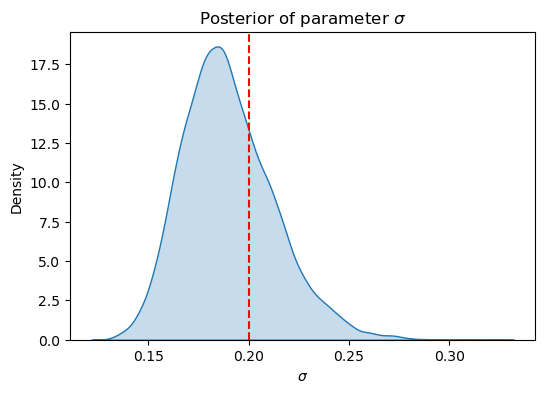

In [17]:
sigma_posterior = posterior_samples['sigma']


plt.figure(figsize=(6, 4))
sns.kdeplot(sigma_posterior, fill=True)
plt.axvline(x=0.2, color='r', linestyle='--', label='True value')
plt.xlabel('$\sigma$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\sigma$')

# Show the plot
plt.show()

## Inference with Numpyro: estimating noise and lengthscale

What about inferring lengthscale too?

In [18]:
def model(x, y=None, kernel_func=rbf_kernel, lengthcsale=None, jitter=1e-5):    
    """
    Gaussian Process prior with a Numpyro model.

    Args:
    - x (jax.numpy.ndarray): Input data points of shape (n, d), where n is the number of points and d is the number of dimensions.
    - kernel_func (function): Kernel function to use. Default is rbf_kernel.
    - lengthscale (float): Length scale parameter for the kernel function. Default is 0.2.
    - jitter (float): Small constant added to the diagonal of the kernel matrix for numerical stability. Default is 1e-5.

    Returns:
    - numpyro.sample: A sample from the Multivariate Normal distribution representing the function values at input points.
    """

    n = x.shape[0]

    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))

    if lengthcsale is None:
        #lengthcsale = numpyro.sample("lengthcsale", dist.HalfCauchy(1))
        lengthcsale = numpyro.sample("lengthcsale", dist.Gamma(2, 10))

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))

    
    if y is None:
        numpyro.sample("y", dist.Normal(f, sigma))
    else:
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [19]:
# WARNING: This cell may take a long time to run

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=1000, num_chains=2, chain_method='parallel')
mcmc.run(jax.random.PRNGKey(42), x, y_obs)

# Print summary statistics of posterior
mcmc.print_summary()

# Get the posterior samples
posterior_samples = mcmc.get_samples()

Running chain 1: 100%|██████████| 5000/5000 [06:26<00:00, 12.95it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         f[0]      0.35      0.57      0.13     -0.22      1.02      1.01      7.52
         f[1]      0.39      0.62      0.22     -0.23      1.08      1.01     10.98
         f[2]      0.33      0.78      0.19     -0.45      1.17      1.00     16.84
         f[3]      0.52      0.72      0.39     -0.20      1.29      1.00     16.48
         f[4]      0.59      0.80      0.47     -0.21      1.44      1.00     18.24
         f[5]      0.84      0.71      0.72      0.12      1.61      1.00     16.23
         f[6]      0.95      0.78      0.84      0.17      1.79      1.00     18.05
         f[7]      1.05      0.88      0.94      0.16      1.99      1.00     20.70
         f[8]      1.14      0.98      1.03      0.16      2.18      1.00     23.16
         f[9]      1.23      1.07      1.12      0.16      2.36      1.00     25.38
        f[10]      1.32      1.14      1.21      0.18      2.52      1.00  

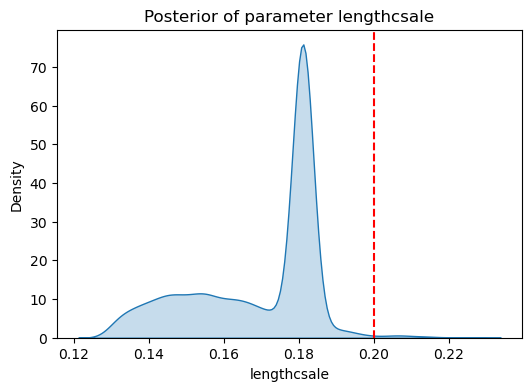

In [23]:
ls_posterior = posterior_samples['lengthcsale']


plt.figure(figsize=(6, 4))
sns.kdeplot(ls_posterior, fill=True)
plt.axvline(x=0.2, color='r', linestyle='--', label='True value')
plt.xlabel('lengthcsale')
plt.ylabel('Density')
plt.title('Posterior of parameter lengthcsale')

# Show the plot
plt.show()

## Poisson regression with Gaussian process latent field